# 1. Exploring and ingesting satelligence data

Methodology based on following document: https://docs.google.com/document/d/1NHhOUOcJBOme_wv344cIMPIpdOX6_tBDCzIZeMY6h6I/edit



In [22]:
#!pip install h3 --quiet
!pip install h3pandas --quiet

In [23]:
from psycopg2.pool import ThreadedConnectionPool
import geopandas as gpd

import folium
import matplotlib.pyplot as plt

#import h3
import h3pandas


In [24]:
env_path = ".env"
with open(env_path) as f:
    env = {}
    for line in f:
        env_key, _val = line.split("=", 1)
        env_value = _val.split("\n")[0]
        env[env_key] = env_value
        

In [25]:

postgres_thread_pool = ThreadedConnectionPool(1, 50,
                                              host=env['API_POSTGRES_HOST'],
                                              port=env['API_POSTGRES_PORT'],
                                              user=env['API_POSTGRES_USERNAME'],
                                              password=env['API_POSTGRES_PASSWORD']
                                              )

## 1 Deforestation linked to given commodity:

- Deforestation data has been ingested as a mask. We may want to ingest that info as portion defoorested as we are doing an upsample.

INPUTS:

● deforestation map (yearly binary raster, generated by Satelligence) ● Location of all palm oil mills (UML from GFW) 
● location of mills related to palm oil for company X (open data from company mill lists , provided by Satelligence or provided by the organization) 


Procedure:

1. Retrieve all deforestation pixels within a 50 km radius for all mills within the UML. 

2. Calculate deforestation extent as sum of those pixels times the pixel’s area for each mill. 

3. The indicator is then the total deforestation within the sourcing area of a mill 

4. Commodity scenarios: analyze e.g. mean and percentage deforestation for given commodity as a whole (in country or world) compared to the same values for company X (i.e. for mills company X is sourcing from:

    a. Mean deforestation of all mills (all mills within a country, world) 
    
    b. % of deforestation within current supply chain (all mills of company X) compared to all deforestation within all mills 
    
    
IN order to check outputs we are going the explore the same use case tested by satelligence in the following document: https://drive.google.com/drive/folders/17QFIsxr2SZh8KBAaCSsek8KBPsbdVPz_




In [26]:
# retrieve all palm oil sourcing records in Aceh, Sumatra, Indonesia

!ls ../../datasets/processed/palm_oil_mills


gadm36_IDN_1.cpg     gadm36_IDN_3.dbf	  palm_mills_50km.prj
gadm36_IDN_1.dbf     gadm36_IDN_3.prj	  palm_mills_50km.shp
gadm36_IDN_1.prj     gadm36_IDN_3.shp	  palm_mills_50km.shx
gadm36_IDN_1.shp     gadm36_IDN_3.shx	  palm_mills.cpg
gadm36_IDN_1.shx     gadm36_IDN_4.cpg	  palm_mills.dbf
gadm36_IDN_1_sp.rds  gadm36_IDN_4.dbf	  palm_mills_in_Aceh.csv
gadm36_IDN_2.cpg     gadm36_IDN_4.prj	  palm_mills.shp
gadm36_IDN_2.dbf     gadm36_IDN_4.shp	  palm_mills.shx
gadm36_IDN_2.prj     gadm36_IDN_4.shx	  Palm_Oil_Mill_List.csv
gadm36_IDN_2.shp     license.txt	  Palm_Oil_Mill_List.xlsx
gadm36_IDN_2.shx     palm_mills_50km.cpg
gadm36_IDN_3.cpg     palm_mills_50km.dbf


In [27]:
IND_df = gpd.read_file('../../datasets/processed/palm_oil_mills/gadm36_IDN_1.shp')
IND_df = IND_df[IND_df['NAME_1']=='Aceh']
IND_df

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"MULTIPOLYGON (((96.66509 2.12018, 96.66765 2.1..."


In [28]:
mills_df = gpd.read_file('../../datasets/processed/palm_oil_mills/palm_mills.shp')
mills_df.head()

,No.,Parent Com,Mill Name,Latitute,Longitude,Country,geometry
0,1,AAA,Mustika Agro Sari,-0.1133,101.2933,Indonesia,POINT (101.29330 -0.11330)
1,2,AAA,Pt. Djaya Globalindo Sentosa,1.6946,101.0430,Indonesia,POINT (101.04300 1.69460)
2,3,AAA,Sumber Jaya Indahnusa,0.8922,100.6990,Indonesia,POINT (100.69900 0.89220)
3,4,AAA,Tamora Agro Lestari,-0.5305,101.4172,Indonesia,POINT (101.41720 -0.53050)
4,5,Aathi Bagawathi Manufacturing Sdn Bhd,Abdi Budi Mulia,2.0513,100.2523,Indonesia,POINT (100.25230 2.05130)


In [29]:
j_df = mills_df.sjoin(IND_df, how="inner")
j_df.head()

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1938: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


,No.,Parent Com,Mill Name,Latitute,Longitude,Country,geometry,index_right,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1
57,58,Anugrah Fajar Rezeki,Anugrah Fajar Rezeki,4.5743,97.9097,Indonesia,POINT (97.90970 4.57430),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC
74,75,Astra Agro Lestari,Karya Tanah Subur,4.3497,96.1644,Indonesia,POINT (96.16440 4.34970),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC
78,79,Astra Agro Lestari,Perkebunan Lembah Bhakti,2.3142,97.9957,Indonesia,POINT (97.99570 2.31420),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC
79,80,Astra Agro Lestari,Perkebunan Lembah Bhakti 2,2.5606,97.9487,Indonesia,POINT (97.94870 2.56060),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC
92,93,Bahari Dwikencana Lestari,Bahari Dwikencana Lestari,4.3565,98.1062,Indonesia,POINT (98.10620 4.35650),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC


In [30]:
j_df.to_csv('../../datasets/processed/palm_oil_mills/palm_mills_in_Aceh.csv')

In [31]:
# Stamen Terrain

mill_gjson = j_df.to_json() 
mill_locations = folium.features.GeoJson(mill_gjson)

map = folium.Map(location = [4.49,97], tiles = "Stamen Terrain", zoom_start = 7)
map.add_child(mill_locations)
map

In [32]:
print(j_df.crs)
if not j_df.crs:
    #set crs in meters
    j_df = j_df.set_crs('EPSG:4326')
    #reproject to meters
    j_df = j_df.to_crs('EPSG:3857')
    
    print('Datasets projection:', j_df.crs)

None
Datasets projection: EPSG:3857


In [33]:
#get a 50 km buffer around those locations
df_50b = j_df.buffer(50000)
j_df['50km_buffer']= df_50b
j_df_50b = j_df.set_geometry('50km_buffer')
j_df_50b.head()

,No.,Parent Com,Mill Name,Latitute,Longitude,Country,geometry,index_right,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,50km_buffer
57,58,Anugrah Fajar Rezeki,Anugrah Fajar Rezeki,4.5743,97.9097,Indonesia,POINT (10899257.948 509750.550),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((10949257.948 509750.550, 10949017.18..."
74,75,Astra Agro Lestari,Karya Tanah Subur,4.3497,96.1644,Indonesia,POINT (10704972.040 484672.167),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((10754972.040 484672.167, 10754731.27..."
78,79,Astra Agro Lestari,Perkebunan Lembah Bhakti,2.3142,97.9957,Indonesia,POINT (10908831.424 257685.639),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((10958831.424 257685.639, 10958590.66..."
79,80,Astra Agro Lestari,Perkebunan Lembah Bhakti 2,2.5606,97.9487,Indonesia,POINT (10903599.408 285139.621),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((10953599.408 285139.621, 10953358.64..."
92,93,Bahari Dwikencana Lestari,Bahari Dwikencana Lestari,4.3565,98.1062,Indonesia,POINT (10921132.228 485431.330),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((10971132.228 485431.330, 10970891.46..."


In [34]:
j_df_50b = j_df_50b.to_crs('EPSG:4326')
j_df_50b

,No.,Parent Com,Mill Name,Latitute,Longitude,Country,geometry,index_right,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,50km_buffer
57,58,Anugrah Fajar Rezeki,Anugrah Fajar Rezeki,4.5743,97.9097,Indonesia,POINT (10899257.948 509750.550),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.35886 4.57430, 98.35669 4.53041, ..."
74,75,Astra Agro Lestari,Karya Tanah Subur,4.3497,96.1644,Indonesia,POINT (10704972.040 484672.167),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((96.61356 4.34970, 96.61139 4.30580, ..."
78,79,Astra Agro Lestari,Perkebunan Lembah Bhakti,2.3142,97.9957,Indonesia,POINT (10908831.424 257685.639),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.44486 2.31420, 98.44269 2.27021, ..."
79,80,Astra Agro Lestari,Perkebunan Lembah Bhakti 2,2.5606,97.9487,Indonesia,POINT (10903599.408 285139.621),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.39786 2.56060, 98.39569 2.51662, ..."
92,93,Bahari Dwikencana Lestari,Bahari Dwikencana Lestari,4.3565,98.1062,Indonesia,POINT (10921132.228 485431.330),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.55536 4.35650, 98.55319 4.31260, ..."
116,117,Beurata Subur Persada,Beurata Subur Persada,4.1252,96.3415,Indonesia,POINT (10724686.722 459612.422),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((96.79066 4.12520, 96.78849 4.08129, ..."
124,125,Blang Ketumba,Blang Ketumba,4.9850,96.7000,Indonesia,POINT (10764594.760 555629.106),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((97.14916 4.98500, 97.14699 4.94114, ..."
125,126,Blang Ketumba,Teupin Lada,5.0511,97.5697,Indonesia,POINT (10861409.321 563015.636),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.01886 5.05110, 98.01669 5.00724, ..."
229,230,Duta Marga,Samudera Sawit Nabati,2.7667,97.9367,Indonesia,POINT (10902263.574 308107.396),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((98.38586 2.76670, 98.38369 2.72273, ..."
251,252,Fajar Baizury & Brothers,Fajar Baizury & Brothers,4.1162,96.4426,Indonesia,POINT (10735941.123 458607.950),0,IDN,Indonesia,IDN.1_1,Aceh,None,None,Propinisi,Province,11,ID.AC,"POLYGON ((96.89176 4.11620, 96.88959 4.07229, ..."


In [35]:
j_df_50b[['50km_buffer']].to_file('../../datasets/processed/palm_oil_mills/palm_mills_50km.shp')

<ipython-input-35-fae8b65c7d0b>:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  j_df_50b[['50km_buffer']].to_file('../../datasets/processed/palm_oil_mills/palm_mills_50km.shp')


In [36]:
#convert those locations to h3 indexes
clean_df= j_df_50b[['Mill Name','50km_buffer']]
clean_df.head()

,Mill Name,50km_buffer
57,Anugrah Fajar Rezeki,"POLYGON ((98.35886 4.57430, 98.35669 4.53041, ..."
74,Karya Tanah Subur,"POLYGON ((96.61356 4.34970, 96.61139 4.30580, ..."
78,Perkebunan Lembah Bhakti,"POLYGON ((98.44486 2.31420, 98.44269 2.27021, ..."
79,Perkebunan Lembah Bhakti 2,"POLYGON ((98.39786 2.56060, 98.39569 2.51662, ..."
92,Bahari Dwikencana Lestari,"POLYGON ((98.55536 4.35650, 98.55319 4.31260, ..."


In [37]:
clean_df= clean_df.rename(columns = {'50km_buffer':'geometry'})

In [38]:
#retrieve from database the pixels that have deforesttaion

dfh3 = clean_df.h3.polyfill_resample(6)
dfh3.head()

,index,Mill Name,geometry
h3_polyfill,,,
86650baafffffff,57,Anugrah Fajar Rezeki,"POLYGON ((97.81643 4.83359, 97.81936 4.87001, ..."
86650b847ffffff,57,Anugrah Fajar Rezeki,"POLYGON ((98.08889 4.64769, 98.09185 4.68409, ..."
866509637ffffff,57,Anugrah Fajar Rezeki,"POLYGON ((97.61824 4.35435, 97.62115 4.39073, ..."
86650b837ffffff,57,Anugrah Fajar Rezeki,"POLYGON ((98.31547 4.68509, 98.31846 4.72148, ..."
86650b8c7ffffff,57,Anugrah Fajar Rezeki,"POLYGON ((98.13398 4.80907, 98.13695 4.84549, ..."


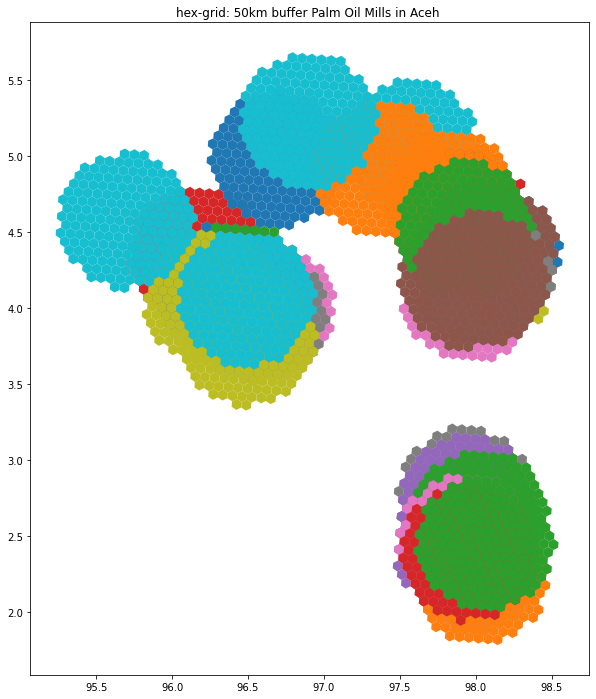

In [39]:
dfh3.plot(figsize=(16, 12), column='Mill Name', legend=False)
plt.title('hex-grid: 50km buffer Palm Oil Mills in Aceh ');

In [1]:
#retrieve all deforestation that is within those pixels:

2/4

0.5